In [170]:
import numpy as np
import pandas as pd
import lightgbm

import warnings
warnings.filterwarnings("ignore")

In [171]:
def apk(actual, predicted, k=10):
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

In [172]:
df_train = pd.read_csv('df_train.csv', sep=';')
df_test = pd.read_csv('df_test.csv', sep=';')

df_train['Data'] = df_train.Data.apply(lambda s: list(map(int, s.split(','))))
df_train['Target'] = df_train.Target.apply(lambda s: list(map(int, s.split(','))))
df_test['Data'] = df_test.Data.apply(lambda s: list(map(int, s.split(','))))

In [173]:
top_codes = df_train['Data'].explode().value_counts().index
top10_codes = top_codes[:10]

In [174]:
# для тренировки и валидации будут использоваться данные из тестового датасета

def split_data(data, new_targets):
    targets = data[-10:]
    new_targets.append(targets)
    data = data[:-10]
    return data
    

def make_training_df_from_testing_df():
    new_targets = []
    new_df = pd.DataFrame()
    new_df['Data'] = df_test['Data'].apply(split_data, args=(new_targets,))
    new_df['Target'] = new_targets
    
    return new_df

df_train_tail = make_training_df_from_testing_df()
df_train_full = pd.concat([df_train.drop('Id', axis=1), df_train_tail], ignore_index=True)
df_train_full = df_train_full.sample(frac=1).reset_index()
df_train_full.drop('index', axis=1, inplace=True)

In [175]:
split_index = int(df_train_full.shape[0] * 0.8)

train_df = df_train_full[:split_index]
validation_df = df_train_full[split_index:]
validation_df.reset_index(inplace=True)

In [176]:
# функции для расчёта фич

def calculate_num_last_k(mss, data_list, k):
    num = 0
    l = data_list[-k:]
    for el in l:
        if el == mss:
            num += 1
    return num

def calculate_first_ind(mss, data_list):
    for i in range(len(data_list) - 1, -1, -1):
        if data_list[i] == mss:
            return i

def calculate_ind_in_top(mss):
    for i in range(len(top_codes)):
        if top_codes[i] == mss:
            return i + 1
    
def calculate_num_in_k_after_last(mss, data_list, k=10):
    num = 0
    last = data_list[-1]
    for i in range(len(data_list)):
        if data_list[i] == last:
            left, right = i + 1, min(i + k, len(data_list) - 1)
            for j in range(left, right + 1):
                if data_list[j] == mss:
                    num += 1
    return num

In [177]:
def get_feachered_df(initial_df):
    if 'Target' in initial_df.columns:
        no_relevance = False
    else:
        no_relevance = True
    
    df = pd.DataFrame()

    for i in range(initial_df.shape[0]):
        if no_relevance:
            mss_list = np.unique(np.concatenate([
                np.unique(initial_df['Data'][i]),
                top10_codes
            ]))
        else:
            mss_list = np.unique(np.concatenate([
                np.unique(initial_df['Data'][i]),
                top10_codes,
                np.unique(initial_df['Target'][i])
            ]))
            
        df_temp = pd.DataFrame({
            'person_id': [i]*len(mss_list),
            'mss_id': mss_list,
            'mss_count': [initial_df['Data'][i].count(mss) for mss in mss_list],
            'num_last_40': [calculate_num_last_k(mss, initial_df['Data'][i], 40) for mss in mss_list],
            'first_ind': [calculate_first_ind(mss, initial_df['Data'][i]) for mss in mss_list],
            'i_in_top': [calculate_ind_in_top(mss) for mss in mss_list],
            'data_len': [len(initial_df['Data'][i])]*len(mss_list),
            'num_in_10_after_last': [calculate_num_in_k_after_last(mss, initial_df['Data'][i]) for mss in mss_list],
        })
        
        if not no_relevance:
            df_temp['relevance'] = [int(mss in initial_df['Target'][i]) for mss in mss_list]
            
        df = pd.concat([df, df_temp], ignore_index=True)
    
    return df

In [178]:
feachered_train_df = get_feachered_df(train_df)
feachered_validation_df = get_feachered_df(validation_df)

In [179]:
qids_train = feachered_train_df.groupby("person_id")["person_id"].count().to_numpy()
X_train = feachered_train_df.drop(['person_id', "mss_id", "relevance"], axis=1)
y_train = feachered_train_df["relevance"]

qids_validation = feachered_validation_df.groupby("person_id")["person_id"].count().to_numpy()
X_validation = feachered_validation_df.drop(['person_id', "mss_id", "relevance"], axis=1)
y_validation = feachered_validation_df["relevance"]

In [180]:
model = lightgbm.LGBMRanker(
    objective='lambdarank',
    n_estimators=10,
    num_leaves=13
)

model.fit(
    X=X_train,
    y=y_train,
    group=qids_train,
    #eval_set=[(X_validation, y_validation)],
    #eval_group=[qids_validation],
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1246
[LightGBM] [Info] Number of data points in the train set: 265611, number of used features: 6


LGBMRanker(n_estimators=10, num_leaves=13, objective='lambdarank')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

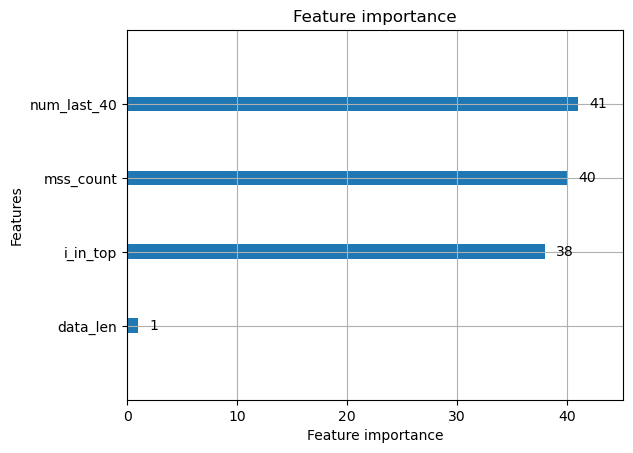

In [181]:
lightgbm.plot_importance(model)

In [182]:
# тест на валидационном сете
if 'preds' in feachered_validation_df.columns:
    feachered_validation_df.drop(['preds'], axis=1, inplace=True)

feachered_validation_df['preds'] = model.predict(
    feachered_validation_df.drop(['person_id', 'mss_id', 'relevance'], axis=1).to_numpy())

ranked_preds = []
for person in np.unique(feachered_validation_df['person_id'].to_numpy()):
    temp_df = feachered_validation_df[feachered_validation_df['person_id'] == person]
    
    mss_top_list = temp_df.sort_values(by='preds')[::-1][:10]['mss_id'].to_numpy()    
    ranked_preds.append(mss_top_list)
    
validation_df['Predicted'] = ranked_preds

print('map@10 score:', mapk(validation_df['Target'], validation_df['Predicted']))
print('Max map@10 score:', mapk(validation_df['Target'], validation_df['Target']))

map@10 score: 0.35937974526460664
Max map@10 score: 0.3801436976117147


In [183]:
# предсказания для тестового датасета
feachered_df_test = get_feachered_df(df_test)

if 'preds' in feachered_df_test.columns:
    feachered_df_test.drop(['preds'], axis=1, inplace=True)

feachered_df_test['preds'] = model.predict(feachered_df_test.drop(['person_id', "mss_id"], axis=1).to_numpy())

Далее приведены две ячейки, в которых происходит формирование последовательностей следующих покупок пользователей для тестового датасета. В первой ячейке для каждого пользователя сначала отбираются коды, для которых релевантность превышает 0.9, затем к ним добавляются топ 10 кодов по релевантности. До дедлайна я не понимал, почему этот способ выдаёт скор больше, чем если просто разместить топ 10 кодов без повторов, так как это никак не состыковывалось с метрикой map@10. Но после дедлайна я выяснил, что лучше было загружать сабмит без квадратных скобок по бокам, и убрав эти скобки и дубликаты, скор вырос до 0.29 (код во второй ячейке).

In [184]:
# сабмит, набирающий 0.25 на лидерборде
def calculate_ranked_preds(feachered_df_test):
    ranked_preds = []
    for person in np.unique(feachered_df_test['person_id'].to_numpy()):
        temp_df = feachered_df_test[feachered_df_test['person_id'] == person]
        mss_top_list = np.concatenate([
            temp_df[temp_df['preds'] > 0.9].sort_values(by='preds')[::-1]['mss_id'].to_numpy(),
            temp_df.sort_values(by='preds')[::-1][:10]['mss_id'].to_numpy()
        ])

        ranked_preds.append(mss_top_list.astype('int'))
    return ranked_preds

ranked_preds = calculate_ranked_preds(feachered_df_test)
df_test['Predicted'] = ranked_preds

submission = df_test[['Id', 'Predicted']]
submission['Predicted'] = submission['Predicted'].astype(str).str.replace(',', '')
submission.to_csv('submission_0.25_score.csv', index=False)

In [185]:
# сабмит, набирающий 0.29 на лидерборде
def calculate_ranked_preds(feachered_df_test):
    ranked_preds = []
    for person in np.unique(feachered_df_test['person_id'].to_numpy()):
        temp_df = feachered_df_test[feachered_df_test['person_id'] == person]
        mss_top_list = temp_df.sort_values(by='preds')[::-1][:10]['mss_id'].to_numpy()

        ranked_preds.append(mss_top_list.astype('int'))
    return ranked_preds

ranked_preds = calculate_ranked_preds(feachered_df_test)
df_test['Predicted'] = ranked_preds

def no_braces(preds):
    return preds[1:-2]

submission = df_test[['Id', 'Predicted']]
submission['Predicted'] = submission['Predicted'].astype(str).str.replace(',', '')
submission['Predicted'] = submission['Predicted'].apply(no_braces)
submission.to_csv('submission_0.29_score.csv', index=False)